# Reproducing and extending diffeq_pendulum.cpp - Pass 4

Pass 4: Exploring animation

* Created 27-Dec-2018 by Dick Furnstahl (furnstahl.1@osu.edu)
* Last revised 27-Dec-2018 by Dick Furnstahl (furnstahl.1@osu.edu).

In [ ]:
import numpy as np
from scipy.integrate import ode, odeint

import matplotlib.pyplot as plt

## Pendulum code

In [ ]:
class Pendulum():
    """
    Pendulum class implements the parameters and differential equation from 
     the diffeq_pendulum.cpp code.
     
    Parameters
    ----------
    omega0 : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the pendulum length) 
    alpha : float
        coefficient of friction 
    f_ext : float
        amplitude of external force 
    omega_ext : float
        frequency of external force 
    phi_ext : float
        phase angle for external force 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, given time t
        and the corresponding value of y.
    """
    def __init__(self,
                 omega0=1.,
                 alpha=0.2,
                 f_ext=0.2,
                 omega_ext=0.689,
                 phi_ext=0.
                ):
        self.omega0 = omega0
        self.alpha = alpha
        self.f_ext = f_ext
        self.omega_ext = omega_ext
        self.phi_ext = phi_ext
    
    def dy_dt(self, y, t):
        """
        This function returns the right-hand side of the diffeq: [dtheta/dt d^2theta/dt^2]
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = theta(t) and y[1] = dtheta/dt
        t : float
            time 
            
        Returns
        -------
        
        """
        F_ext = self.f_ext * np.cos(self.omega_ext*t + self.phi_ext)
        return [y[1], -self.omega0**2*np.sin(y[0]) - self.alpha*y[1] + F_ext]

In [ ]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, ax=None):
    """
    Return a figure axis with a plot of y vs. x. 
    """
    if ax is None:
        ax = plt.gca()

    ax.plot(x, y, label=label)
    if label is not None:
        ax.legend()
    if title is not None:
        ax.set_title(title)
    if axis_labels is not None:    
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax


## Interface using ipywidgets with interactive_output

In [ ]:
# Import the widgets we will use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, Dropdown, HTMLMath

from IPython.display import display
from time import sleep

In [ ]:
# This function generates the main output, which is a grid of plots
def pendulum_plots(theta_vs_time_plot=True, theta_dot_vs_time_plot=True, 
                   phase_space_plot=True, omega0=1., 
                   alpha=0.2, f_ext=0.2, omega_ext=0.689, phi_ext=0., 
                   theta0=0.8, theta_dot0=0.0, 
                   t_start=0, t_end=100, delta_t=0.1, plot_start=0, 
                   font_size=18):
    """
    Create plots for interactive_output according to the inputs.
    
    Based on generating a Pendulum instance and the requested graphs.
    
    Notes
    -----
        1. We generate a new Pendulum instance every time *and* solved
            the ODE every time, even if the only change is to parameters
            like t_start and t_end.  Should we care or is this just so
            cheap to recalculate that it doesn't matter?
            How could we structure this differently?
    """

    # add delta_t o it goes at least to t_end (probably should use linspace)
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
        
    # Instantiate a pendulum with the passed (or default) values of the 
    #  natural frequency omega0, damping alpha, driving amplitude, frequency, 
    #  and phase (f_ext, omega_ext, phi_ext).
    #  Should we delete p1 at some point?  Is there a memory issue?
    p1 = Pendulum(omega0=omega0, alpha=alpha, f_ext=f_ext, omega_ext=omega_ext, 
                  phi_ext=phi_ext)
    y0 = [theta0, theta_dot0]  # initial conditions for the pendulum ODE

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # For now we solve with odeint; give more options in the future.
    theta, theta_dot = odeint(p1.dy_dt, y0, t_pts,
                              atol=abserr, rtol=relerr).T
    
    # Update the common font size
    plt.rcParams.update({'font.size': font_size})
 
    # Labels for individual plot axes
    theta_vs_time_labels = (r'$t$', r'$\theta$')
    theta_dot_vs_time_labels = (r'$t$', r'$d\theta/dt$')
    phase_space_labels = (r'$\theta$', r'$d\theta/dt$')
    
    # Figure out how many rows and columns [one row for now]
    plot_flags = [theta_vs_time_plot, theta_dot_vs_time_plot, phase_space_plot]
    plot_num = plot_flags.count(True)
    plot_rows = 1
    figsize_rows = plot_rows*4  # 6
    plot_cols = plot_num
    figsize_cols = min(plot_cols*6, 10)  # 8, 16
    
    # Make the plot!
    fig, axes = plt.subplots(plot_rows, plot_cols, 
                             figsize=(figsize_cols,figsize_rows))
                             #num='This is a test')
    axes = np.atleast_1d(axes)  # make it always a 1d array, even if only 1

    start_index = (np.fabs(t_pts-plot_start)).argmin() # finds nearest index
    
    next_axes = 0
    if theta_vs_time_plot:
        plot_y_vs_x(t_pts, theta, axis_labels=theta_vs_time_labels, 
                    label='pendulum', title=r'$\theta$ vs. time', 
                    ax=axes[next_axes])    
        # add a line where the phase space plot starts
        axes[next_axes].axvline(t_pts[start_index], lw=3, color='red')
        next_axes += 1
    
    if theta_dot_vs_time_plot:
        plot_y_vs_x(t_pts, theta_dot, axis_labels=theta_dot_vs_time_labels, 
                    label='pendulum', title=r'$d\theta/dt$ vs. time', 
                    ax=axes[next_axes])    
        # add a line where the phase space plot starts
        axes[next_axes].axvline(t_pts[start_index], lw=3, color='red')
        next_axes += 1

    if phase_space_plot:
        plot_y_vs_x(theta[start_index:-1], theta_dot[start_index:-1], 
                    axis_labels=phase_space_labels, title='Phase space', 
                    ax=axes[next_axes])    
        next_axes += 1
    
    fig.tight_layout()



In [ ]:

# Widgets for the various inputs.
#   For any widget, we can set continuous_update=False if we don't want the 
#    plots to shift until the selection is finished (particularly relevant for 
#    sliders).

# Widgets for the plot choice (plus a label out front)
plot_choice_w = Label(value='Which plots: ',layout=Layout(width='100px'))
def plot_choice_widget(on=True, plot_description=None):
    return Checkbox(value=on, description=plot_description,
                  disabled=False, indent=False, layout=Layout(width='150px'))
theta_vs_time_plot_w = plot_choice_widget(True, r'$\theta$ vs. time')
theta_dot_vs_time_plot_w = plot_choice_widget(False, r'$d\theta/dt$ vs. time')
phase_space_plot_w = plot_choice_widget(True, 'phase space')

# Widgets for the pendulum parameters
def float_widget(value, min, max, step, description, format):
    slider_border = Layout(border='solid 1.0px')
    return FloatSlider(value=value,min=min,max=max,step=step,disabled=False,
                       description=description,continuous_update=False,
                       orientation='horizontal',layout=slider_border,
                       readout=True,readout_format=format)
omega0_w = float_widget(value=1.0, min=0.0, max=10., step=0.1,
                        description=r'natural $\omega_0$:', format='.1f')
alpha_w = float_widget(value=0.1, min=0.0, max=2., step=0.1,
                       description=r'damping $\alpha$:', format='.1f')
f_ext_w = float_widget(value=0.2, min=0.0, max=2., step=0.05,
                       description=r'strength $f_{\rm ext}$:', format='.2f')
omega_ext_w = float_widget(value=0.689,min=0.0,max=3.,step=0.1,
                       description=r'freq. $\omega_{\rm ext}$:', format='.2f')
phi_ext_w = float_widget(value=0.0, min=0, max=2.*np.pi, step=0.1,
                         description=r'phase $\phi_{\rm ext}$:', format='.1f')

# Widgets for the initial conditions
theta0_w = float_widget(value=0.8, min=0., max=2.*np.pi, step=0.1,
                        description=r'$\theta_0$:', format='.1f')
theta_dot0_w = float_widget(value=0.0, min=-10., max=10., step=0.1,
                            description=r'$(d\theta/dt)_0$:', format='.1f')

# Widgets for the plotting parameters
t_start_w = float_widget(value=0., min=0., max=100., step=10.,
                         description='t start:', format='.1f') 
t_end_w = float_widget(value=100., min=0., max=500., step=10.,
                       description='t end:', format='.1f')
delta_t_w = float_widget(value=0.1, min=0.01, max=0.2, step=0.01,
                         description='delta t:', format='.2f')
plot_start_w = float_widget(value=0., min=0., max=300., step=5.,
                            description='start plotting:', format='.1f')

# Widgets for the styling parameters
font_size_w = Dropdown(options=['12', '16', '18', '20', '24'], value='18',
                       description='Font size:',disabled=False,
                       continuous_update=False,layout=Layout(width='140px'))

# Text for the help section
overview_text = \
   r"""<p>Here we explore the dynamics of a damped, driven pendulum. There is help 
          available under the other tabs.</p>  
          <ul>
            <li>Physics tab: find out about the equations being solved.
            <li>Plotting tab: adjust what is plotted and over what intervals.  
                Also about the algorithm used.
            <li>Styling tab: change how the plots look.
            <li>Animate tab: look at animated plots of the time dependence.
          </ul>      
    """ 
physics_text = \
   r"""<p>We have in mind a physical pendulum with moment of inertia $I$ for which 
       the dependent variable is the angle $\theta$.  It is subject to gravity, 
       a damping force proportional to $d\theta/dt \equiv \dot\theta$, and an external 
       periodic driving torque.  Newton's second law for the torque can be rearranged to
       give the differential equation:
       \begin{align}
         \qquad
         \frac{d^2\theta}{dt^2} + \alpha \frac{d\theta}{dt}
           + \omega_0^2 \sin\theta = f_{\rm ext}\cos(\omega_{\rm ext}t)
           \; .
       \end{align} 
       The presence of $\sin\theta$ rather than $\theta$ makes this problem
       inherently nonlinear.</p>
              
       <p>To study this system, we'll look at plots such as $\theta$ versus $t$ 
       and the phase-space plot $\dot\theta$ vs. $\theta$, given initial
       conditions $\theta_0 \equiv \theta(t=0)$ and 
       $\dot\theta_0 \equiv \dot\theta(t=0)$.
       Under what conditions will these look like the results for a
       simple harmonic oscillator?
       Try to decide what range of $\theta_0$ gives harmonic behavior, 
       given $\dot\theta_0 = 0$.</p>

       <p>Let's think about <em>chaos</em>.  Consider the following brief 
       discussion as a teaser.  Here are some characteristics of chaos:
       <ul>
         <li> The system does not repeat past behavior (cf.\ periodic
         behavior).</li>
         <li> An uncertainty (or variation) in initial conditions grows
         <em>exponentially</em> (rather than linearly) in time.  The consequence
         is that the system is deterministic (as opposed to having a random
         component) but not predictable, since there is a finite precision in
         specifying the initial conditions (e.g., think about round-off
         error).</li>
         <li> The system has a distributed power spectrum.</li>
       </ul>
       The following are necessary conditions for chaotic behavior:
       <ol type="a">
         <li> The system has at least \emph{three} independent dynamical
         variables.  That is, the system can be written as
         \begin{align}
            \qquad\frac{dy_0}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
            \qquad\frac{dy_1}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
                 &  \quad \vdots \\
            \qquad\frac{dy_n}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
         \end{align}
         with $n \geq 3$.</li>
         <li>
           The equations of motion contain nonlinear term(s) that couple
           several of the variables.</li>
       </ol>
       You might not think that our pendulum example qualifies, since there
       only seem to be two independent dynamical variables, $\theta$ and
       $\omega \equiv \dot\theta$.  We find the third by introducing $\phi$
       as
       \begin{align}
         \qquad\phi &= \omega_{\rm ext} t \quad \Longrightarrow \quad
           \frac{d\phi}{dt} = \omega_{\rm ext} \ .
       \end{align}
       Thus, the three necessary equations are
       \begin{align}
         \qquad\frac{d\theta}{dt} &= \omega \ ,\\
         \qquad\frac{d\omega}{dt} &= -\alpha\omega - \omega_0^2 \sin\theta
            - f_{\rm ext}\cos\phi \ ,\\
         \qquad\frac{d\phi}{dt} &= \omega_{\rm ext} \ .
       \end{align}
       Now we satisfy a) with $\theta$, $\omega$, and $\phi$, and we satisfy
       b) since the $\sin\theta$ and $\cos\phi$ terms couple the equations
       nonlinearly.  So we should be able to find chaos!   
    """

plotting_text = \
    """
    <p>Notes on plotting:</p>
    <ul>
      <li>The <tt>plot_start</tt> variable sets when the phase space plot
       starts plotting.  This enables you to remove the transient behavior
       at early ties.
    </ul>
    """

styling_text = \
    """
    <p>For now you can only change the font size.</p>
    """

# Widgets for the help section
help_max_height = '500px'
help_overview_w = HTMLMath(value=overview_text)
help_physics_w = HTMLMath(value=physics_text)
help_plotting_w = HTMLMath(value=plotting_text)
help_styling_w = HTMLMath(value=styling_text)
help_w = Tab(children=[help_overview_w, help_physics_w, 
                       help_plotting_w, help_styling_w], 
             layout=Layout(width='95%', max_height=help_max_height))
help_w.set_title(0, 'Overview')
help_w.set_title(1, 'Physics')
help_w.set_title(2, 'Plotting')
help_w.set_title(3, 'Styling')
help_w.set_title(4, 'Animate')

############## Begin: Explicit callback functions #######################

# Make sure that t_end is at least t_start + 50
def update_t_end(*args):
    if t_end_w.value < t_start_w.value:
        t_end_w.value = t_start_w.value + 50     
t_end_w.observe(update_t_end, 'value')
t_start_w.observe(update_t_end, 'value')


# Make sure that plot_start is at least t_start and less than t_end
def update_plot_start(*args):
    if plot_start_w.value < t_start_w.value:
        plot_start_w.value = t_start_w.value
    if plot_start_w.value > t_end_w.value:
        plot_start_w.value = t_end_w.value
plot_start_w.observe(update_plot_start, 'value')
t_start_w.observe(update_plot_start, 'value')
t_end_w.observe(update_plot_start, 'value')

############## End: Explicit callback functions #######################

# Set up the interactive_output widget 
plot_out = widgets.interactive_output(pendulum_plots,
                          dict(
                          theta_vs_time_plot=theta_vs_time_plot_w,
                          theta_dot_vs_time_plot=theta_dot_vs_time_plot_w,
                          phase_space_plot=phase_space_plot_w,
                          omega0=omega0_w,
                          alpha=alpha_w,
                          f_ext=f_ext_w,
                          omega_ext=omega_ext_w,
                          phi_ext=phi_ext_w,
                          theta0=theta0_w,
                          theta_dot0=theta_dot0_w,
                          t_start=t_start_w,
                          t_end=t_end_w, 
                          delta_t=delta_t_w,    
                          plot_start=plot_start_w,  
                          font_size=font_size_w)
                       )

# Now do some manual layout, where we can put the plot anywhere using plot_out
hbox1 = HBox([plot_choice_w, theta_vs_time_plot_w, theta_dot_vs_time_plot_w,
              phase_space_plot_w]) #  choice of what plots to show
hbox2 = HBox([omega0_w, f_ext_w, omega_ext_w, phi_ext_w])  # external driving parameters
hbox3 = HBox([theta0_w, theta_dot0_w, alpha_w]) # initial conditions and damping
hbox4 = HBox([t_start_w, t_end_w, delta_t_w, plot_start_w]) # time and plot ranges
hbox5 = HBox([font_size_w]) # font size
hbox6 = HBox()  # animate
hbox7 = HBox([help_w])  # help tabs

tab_height = '70px'  # some auto height?
tab0 = VBox([hbox2, hbox3], layout=Layout(min_height=tab_height))
tab1 = VBox([hbox1, hbox4], layout=Layout(min_height=tab_height))
tab2 = VBox([hbox5], layout=Layout(min_height=tab_height))
tab3 = VBox([hbox6], layout=Layout(min_height=tab_height))
tab4 = VBox([hbox7], layout=Layout(min_height=tab_height))

tab = Tab(children=[tab0, tab1, tab2, tab3, tab4])
tab.set_title(0, 'Physics')
tab.set_title(1, 'Plotting')
tab.set_title(2, 'Styling')
tab.set_title(3, 'Animate')
tab.set_title(4, 'Help')


# Release the Kraken!
vbox2 = VBox([tab, plot_out])
display(vbox2)

## Animating the time dependence

Questions:
* How do we get the return value of the function called with interactive_output? We would like to return the fig and axes and be able to use these.

One plan is to create a series of frames and then show them.

In [ ]:
play = widgets.Play(
                    interval=100,
                    value=10,
                    min=0,
                    max=100,
                    step=1,
                    description='Press play',
                    disabled=False
                )
slider = widgets.IntSlider()

widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()

The following example is from https://github.com/jupyter-widgets/ipywidgets/issues/134.

An explanation of the %config line and some other aspects is in https://stackoverflow.com/questions/45341765/matplotlib-inline-causes-error-in-following-code.  We'll quote it here:

By default, figures are closed at the end of a cell. This means that pyplot (plt) has forgotten about the axes to work on in the next cell.  See <code>%config InlineBackend</code> in the next cell.

The solution is thus to set .close_figures to False:

<code>
%config InlineBackend.close_figures=False
</code>
In order to prevent the automatic output of active figures at the end of a cell, you may then set 'plt.ioff()'.


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.close_figures=False
plt.ioff()

fig, axes = plt.subplots(ncols=2)


In [ ]:
ax = axes[0]
ax.set_title("title")
ax.plot([1,3,2])
plt.sca(ax)
plt.xticks([0,1,2],["A","B","C"]);

In [ ]:
fig

In [ ]:
%config InlineBackend

In [ ]:
#%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from IPython.display import display,clear_output

plt.ioff()
ax=plt.gca()
plt.plot(np.random.randn(100),np.random.randn(100),'+')

out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)

def click(b):
    ax.lines[0].set_xdata(np.random.randn(100))
    ax.lines[0].set_ydata(np.random.randn(100))
    with out:
        clear_output(wait=True)
        display(ax.figure)

button.on_click(click)
click(None)

### Another type of example

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def any_function_returning_value(word1,word2):
    new_word = 'Combining words is easy: %s %s'%(word1,word2)
    print(new_word)
    return new_word

class learn_classes_and_widgets():
    def __init__(self, param1 = 'a word', param2 = 'another word'):
        self.p1_text = widgets.Text(description = 'Word #1',value = param1)
        self.p2_text = widgets.Text(description = 'Word #2',value = param2)
        self.p1_text.on_submit(self.handle_submit)
        self.p2_text.on_submit(self.handle_submit)
        display(self.p1_text, self.p2_text)

    def handle_submit(self, text):
        print("Submitting")
        print( "Text " + str(text.value))
        self.w = any_function_returning_value(self.p1_text.value,self.p2_text.value)
        return self.w

f = learn_classes_and_widgets(param1 = 'try this word')

### Basic use of 'display'

In [ ]:
# doesn't seem to work with %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

t = np.linspace(0,2*np.pi,100)
x = np.sin(t)

fig, ax = plt.subplots(1,2,figsize=(8,4))
#l, = ax.plot([0,2*np.pi],[-1,1])
l, = ax[0].plot(t,x)
l2, = ax[0].plot(t[0],x[0],'ro')
l3, = ax[1].plot(t,x**2)
l4, = ax[1].plot(t[0],x[0]**2,'go')

fig.tight_layout()

# Add text in axes coordinates, with lower left (0,0) and upper right (1,1).
time_text = ax[0].text(0.02, 0.95, '', transform=ax[0].transAxes)

#animate = lambda i: l.set_data(t[:i], x[:i])
#animate = lambda i: l2.set_data(t[i], x[i])
def animate(i):
    time_text.set_text('time = %.1f' % t[i])
    l2.set_data(t[i], x[i])
    l4.set_data(t[i], x[i]**2)


for i in range(len(x)):
    animate(i)
    clear_output(wait=True)
    display(fig)
clear_output(wait=True)

plt.show()


In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import time

t = np.linspace(0,2*np.pi,100)
x = np.sin(t)

fig = plt.figure(num='Test of animation',figsize=(6,3))
#, ax = plt.subplots(1,2,figsize=(8,4))
#l, = ax.plot([0,2*np.pi],[-1,1])
ax_left = fig.add_subplot(1,2,1)
ax_right = fig.add_subplot(1,2,2)

l1, = ax_left.plot(t,x)
p1, = ax_left.plot(t[0],x[0],'ro')
l2, = ax_right.plot(t,x**2)
p2, = ax_right.plot(t[0],x[0]**2,'go')

fig.tight_layout()

# Add text in axes coordinates, with lower left (0,0) and upper right (1,1).
time_text = ax_left.text(0.02, 0.95, 'time', transform=ax_left.transAxes)

fig.show()
fig.canvas.draw()

# for i in range(len(t)):
#     p1, = ax_left.plot(t[5],x[5],'ro')
#     #fig.canvas.draw()
#     #fig.canvas.flush_events()
#     time.sleep(.1)

# for i in range(len(t)):
#   p1.remove()
#   p1, = ax_left.plot(t[i],x[i],'ro')
#   p2.remove()
#   p2, = ax_right.plot(t[i],x[i]**2,'go')
#   fig.canvas.draw()
#   time.sleep(.2)
  


In [ ]:
# ax_right.clear()

In [ ]:
for i in range(len(t)):
    p1.remove()
    p1, = ax_left.plot(t[i],x[i],'ro')
    #p2.remove()
    #p2, = ax_right.plot(t[i],x[i]**2,'go')
    ax_right.clear()
    l2, = ax_right.plot(t[:i],x[:i]**2,'go')
    fig.canvas.draw()
    fig.canvas.flush_events()  # seems to keep results cleaner (no strays)
    time.sleep(.1)


In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
#import matplotlib.animation
import numpy as np
# Import the widgets we will use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, Dropdown, HTMLMath, Button

from IPython.display import display, clear_output
from time import sleep



def plot_test(t_start=0, t_end=2*np.pi, delta_t=0.1):
    t = np.linspace(t_start,t_end,100)
    x = np.sin(t)
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    #fig.figure(num='This is the title')

    #l, = ax.plot([0,2*np.pi],[-1,1])
    l1, = ax[0].plot(t,x)
    p1, = ax[0].plot(t[0],x[0],'ro')
    l2, = ax[1].plot(t,x**2)
    p2, = ax[1].plot(t[0],x[0]**2,'go')
  
    fig.tight_layout()
    fig.show()
    fig.canvas.draw()

    return p1, p2, fig

# Add text in axes coordinates, with lower left (0,0) and upper right (1,1).
#time_text = ax[0].text(0.02, 0.95, '', transform=ax[0].transAxes)

# def animate(i):
#     time_text.set_text('time = %.1f' % t[i])
#     l2.set_data(t[i], x[i])
#     l4.set_data(t[i], x[i]**2)

# for i in range(len(x)):
#     animate(i)
#     clear_output(wait=True)
#     display(fig)
# clear_output(wait=True)

# plt.show()

def float_widget(value, min, max, step, description, format):
    slider_border = Layout(border='solid 1.0px')
    return FloatSlider(value=value,min=min,max=max,step=step,disabled=False,
                       description=description,continuous_update=False,
                       orientation='horizontal',layout=slider_border,
                       readout=True,readout_format=format)

animate_button = Button(description='animate', disabled=False)





# Widgets for the plotting parameters
t_start_w = float_widget(value=0., min=0., max=2.*np.pi, step=0.1,
                         description='t start:', format='.1f') 
t_end_w = float_widget(value=2.*np.pi, min=0., max=500., step=10.,
                       description='t end:', format='.1f')
delta_t_w = float_widget(value=0.1, min=0.01, max=0.2, step=0.01,
                         description='delta t:', format='.2f')

# Set up the interactive_output widget 
plot_out = widgets.interactive_output(plot_test,
                          dict(
                          t_start=t_start_w,
                          t_end=t_end_w, 
                          delta_t=delta_t_w)
                       )


def on_button_clicked(b):
    p1, p2, fig = plot_out.result
    p1.remove()
    fig.canvas.draw()
    fig.canvas.flush_events()  # seems to keep results cleaner (no strays)
    print("Clicked!")
    

animate_button.on_click(on_button_clicked)

hbox4 = HBox([t_start_w, t_end_w, delta_t_w]) # time and plot ranges

vbox = VBox([hbox4, animate_button, plot_out])
display(vbox)



In [ ]:
%config InlineBackend.rc

In [ ]:
%config NotebookBackend.rc

In [ ]:
% This generates multiple plots, like above 

import numpy as np
import matplotlib.pyplot as plt

# The following programme runs on version 3.6.
# Code generates a pair of lines and the line 2 is removed in a for loop which
# simulates a comet effect
pts=100
t2 = np.linspace(0.0,5.0,pts)
t2=(t2/50)
tm=t2*(10**3)
nz=t2.size
tc=np.linspace(0.8,2.5,2)
nz=tc.size
for n in range (nz):
    print(tc[n])
    resp = 1 - np.exp(-tc[n]*tm*10**-3*50) * np.cos(2*np.pi*50*tm*10**-3)
    for m in range(pts):
        plt.xlim(0,100)
        plt.ylim(0,2)
        plt.xlabel('Time,in milliseconds',fontsize=12)
        plt.ylabel('Respose',fontsize=12)
        plt.title('Underdamped Second Order System Step Response',fontsize=14)
        line1,=plt.plot(tm[0:m+1],resp[0:m+1],color='black',linewidth=0.2)
        line2,=plt.plot(tm[m],resp[m],marker='o',color='red',markersize=5)
        ax = plt.gca()
        plt.pause(0.02)
        ax.lines.remove(line2)
        plt.grid(True)
plt.show()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from matplotlib import animation
N = 5
M = 100
points_evo_array = np.random.rand(M,N)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, M), ylim=(0, np.max(points_evo_array)))
lines = []

lines = [ax.plot([], [])[0] for _ in range(N)]

def init():    
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    for j,line in enumerate(lines):
        line.set_data(range(i), [points_evo_array[:i,j]])
    return lines

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,np.arange(1, M), init_func=init, interval=10, blit=True)

HTML(anim.to_html5_video())

In [ ]:
# From https://stackoverflow.com/questions/39658717/plot-dynamically-changing-graph-using-matplotlib-in-jupyter-notebook
# Problem: rendering of animation is very small until final figure.
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time

#plt.setp(plt.gca(), autoscale_on=False)

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure(num='Test animation',figsize=(4,3))
ax = fig.add_subplot(111)
plt.ion()   # Do we need this?  On by default?

fig.show()
fig.canvas.draw()
fig.canvas._dpi_ratio = 2

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()
    time.sleep(.1)


### Getting a function return from interactive and interactive_output

In [ ]:
# tryin

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    x = np.linspace(-10, 10, num=1000)
    ax.plot(x, m * x + b)
    p1, = ax.plot([0],[0],'ro')
    ax.set_ylim(-5, 5)
    fig.show()
    return fig, ax, p1

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


In [ ]:
fig2, ax2, p1 = interactive_plot.result

p1.remove()
p1, = ax2.plot([5],[2],'ro')
display(fig2)

In [ ]:
# tryin

%matplotlib inline
from ipywidgets import interactive_output
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    x = np.linspace(-10, 10, num=1000)
    ax.plot(x, m * x + b)
    p1, = ax.plot([0],[0],'ro')
    ax.set_ylim(-5, 5)
    fig.show()
    return fig, ax, p1

interactive_plot = interactive_output(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


### Working with a class and interactive_output

In [1]:
%matplotlib notebook

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output

import time


This works, sort of, but only with the notebook backend.  So must need interactive after all.

Also, we can't get the widgets to display above the plot this way.

<IPython.core.display.Javascript object>


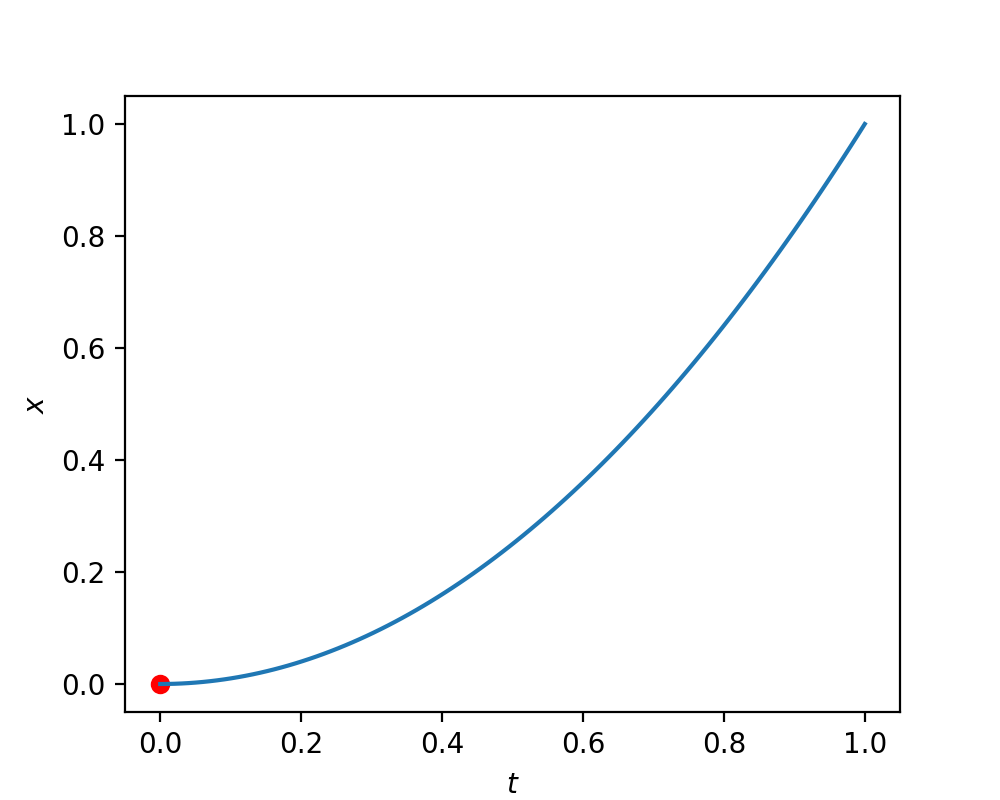

In [2]:
class TestPersistance():
    """
    Simple test case for having a figure in an Output widget together with
    interactive_output in which the components of the figure (e.g., a marker
    dot on a line) are changed without changing the rest of the plot.
    
    This will hopefully make real-time animations faster.
    """
    def __init__(self, t_min=0, t_max=1, num_t=100):
        self.t_min = t_min
        self.t_max = t_max
        self.num_t = num_t
        self.t_pts = np.linspace(self.t_min, self.t_max, self.num_t)
        self.x_pts = np.zeros(len(self.t_pts))
        
        self.fig = plt.figure(figsize=(5,4))
        self.ax = self.fig.add_subplot(1,1,1)
        self.x_vs_time_labels = (r'$t$', r'$x$')
        self.ax.set_xlabel(self.x_vs_time_labels[0])
        self.ax.set_ylabel(self.x_vs_time_labels[1])
        
        self.line, = self.ax.plot(self.t_pts[0], 
                                      self.x_pts[0],
                                      'ro'
                                     )
        
        
    def plot_points(self, animate_flag=False, plot_index=0):
        if animate_flag is False:
            self.x_pts = self.t_pts**2
            self.ax.plot(self.t_pts, self.x_pts)
            #self.fig.show()
        elif animate_flag is True:
            self.line.remove()
            self.line, = self.ax.plot(self.t_pts[plot_index], 
                                      self.x_pts[plot_index],
                                      'ro'
                                     )
        
t_min = 0
t_max = 1
num_t = 100
tp1 = TestPersistance(t_min, t_max, num_t) 
#tp1.plot_points(-1)

# for index in np.arange(len(tp1.t_pts)):
#     tp1.plot_points(index)
#     tp1.fig.show()
#     display(tp1.fig)
#     time.sleep(.1)



In [3]:
# Widgets for the animating
animate_flag_w = Checkbox(value=False, description='Animate',
                  disabled=False, indent=False, layout=Layout(width='100px'))
plot_index_w = Play(interval=10, value=0, min=0, max=num_t-1, step=1, 
                      disabled=False, continuous_update=True,
                      description='press play', 
                      orientation='horizontal')

plot_out = widgets.interactive_output(tp1.plot_points,
                                      dict(
                                           animate_flag=animate_flag_w,
                                           plot_index=plot_index_w
                                          )
                                     )

hbox1 = HBox([animate_flag_w, plot_index_w])  # animate
tab1 = VBox([hbox1])
vbox1 = VBox([tab1, plot_out])
display(vbox1)

### "Convert animation to javascript" examples

This one still seems pretty slow, with no intensive calculations.  Wait, the interval was set to be too long by its default.  Now it flies along.  There is also the possibility of blit.  (To make blit work, simply add `return l2` to the end of the `animate` function.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot(t,x)
l2, = ax.plot(t[0],x[0],'ro')

def animate(i):
    l2.set_data(t[i], x[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t),\
                                        interval=20)
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t),
                                        interval=5)

from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

In [ ]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation


class Scope(object):
    def __init__(self, ax, maxt=2, dt=0.02):
        self.ax = ax
        self.dt = dt
        self.maxt = maxt
        self.tdata = [0]
        self.ydata = [0]
        self.line = Line2D(self.tdata, self.ydata)
        self.ax.add_line(self.line)
        self.ax.set_ylim(-.1, 1.1)
        self.ax.set_xlim(0, self.maxt)

    def update(self, y):
        lastt = self.tdata[-1]
        if lastt > self.tdata[0] + self.maxt:  # reset the arrays
            self.tdata = [self.tdata[-1]]
            self.ydata = [self.ydata[-1]]
            self.ax.set_xlim(self.tdata[0], self.tdata[0] + self.maxt)
            self.ax.figure.canvas.draw()

        t = self.tdata[-1] + self.dt
        self.tdata.append(t)
        self.ydata.append(y)
        self.line.set_data(self.tdata, self.ydata)
        return self.line,


def emitter(p=0.03):
    'return a random value with probability p, else 0'
    while True:
        v = np.random.rand(1)
        if v > p:
            yield 0.
        else:
            yield np.random.rand(1)

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots()
scope = Scope(ax)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, scope.update, emitter, interval=10,
                              blit=True)

plt.show()